(60000, 784)


(-0.5, 27.5, 27.5, -0.5)

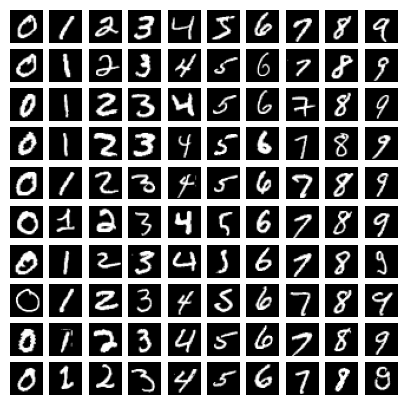

In [3]:
import os, sys
directory_path = os.path.dirname(os.path.abspath("__notebook__"))
sys.path.append('../../')
import numpy as np
import torch
np.random.seed(42)
import matplotlib.pyplot as plt
from models import crbm
from torchvision import datasets
from sklearn.preprocessing import StandardScaler

train_dataset = datasets.MNIST(root='./data', train=True, download=True)
scaler = StandardScaler()
X = train_dataset.data.numpy()
n_examples = X.shape[0]
X = X.reshape(n_examples, -1)
print(X.shape)
X = scaler.fit_transform(X)
y = train_dataset.targets
y_orig = y.numpy().copy()
y = torch.nn.functional.one_hot(y).numpy()
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5, 5))
images = []
for i in range(10):
    images.append(X[y_orig == i][:10])
for j in range(len(images)):
    for k in range(10):
        image = images[k][j].reshape(1, -1)
        image = scaler.inverse_transform(image)
        image = np.clip(np.reshape(image, (28, 28)), 0, 255)
        axes[j][k].imshow(image, cmap='gray')
        axes[j][k].axis('off')
plt.axis('off')

In [4]:
model = crbm.ConditionalRBM(
    n_vis=784,
    n_cond=10,
    n_hid=4000,
    var=None
)
stats = model.fit_autograd(
    X=X[:10000],
    y=y[:10000],
    n_gibbs=1,
    lr=0.001,
    n_epochs=30,
    batch_size=100, 
    gamma=1,
    gamma_delay=50,
    rng_seed=0,
    verbose_interval=1,
    checkpoint_path=f'{directory_path}/crbm_checkpoints/crbm_mnist_demo.pth'
)

epoch: 00 of 30 | loss: 51.681 | recon_mse: 0.223 | kl_data_model: 55.658 | kl_model_data: -328.486
epoch: 01 of 30 | loss: 14.046 | recon_mse: 0.17 | kl_data_model: -13.861 | kl_model_data: -405.169
epoch: 02 of 30 | loss: 12.506 | recon_mse: 0.154 | kl_data_model: -23.482 | kl_model_data: -423.665
epoch: 03 of 30 | loss: 27.514 | recon_mse: 0.108 | kl_data_model: 48.505 | kl_model_data: -436.395
epoch: 04 of 30 | loss: 21.823 | recon_mse: 0.134 | kl_data_model: -25.626 | kl_model_data: -433.821
epoch: 05 of 30 | loss: 14.862 | recon_mse: 0.166 | kl_data_model: 111.479 | kl_model_data: -412.72
epoch: 06 of 30 | loss: 11.622 | recon_mse: 0.17 | kl_data_model: -85.331 | kl_model_data: -437.936
epoch: 07 of 30 | loss: 17.393 | recon_mse: 0.164 | kl_data_model: -81.756 | kl_model_data: -438.503
epoch: 08 of 30 | loss: 21.91 | recon_mse: 0.203 | kl_data_model: -53.509 | kl_model_data: -444.512
epoch: 09 of 30 | loss: 13.908 | recon_mse: 0.13 | kl_data_model: -55.075 | kl_model_data: -442.4

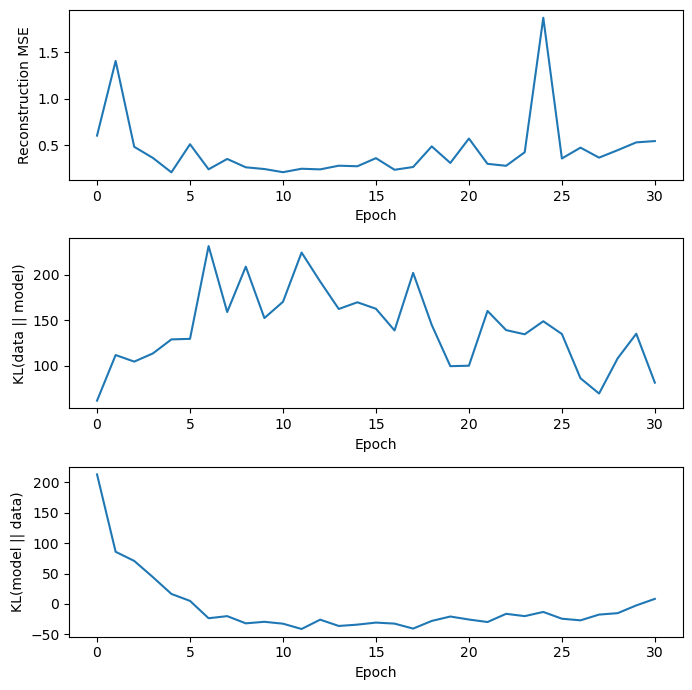

In [44]:
def visualize_learning(stats):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))
    axs[0].plot(stats['epoch_num'], stats['recon_mse'])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Reconstruction MSE')
    axs[1].plot(stats['epoch_num'], stats['kl_data_model'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('KL(data || model)')
    axs[2].plot(stats['epoch_num'], stats['kl_model_data'])
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('KL(model || data)')
    plt.tight_layout()
visualize_learning(stats)

(-0.5, 27.5, 27.5, -0.5)

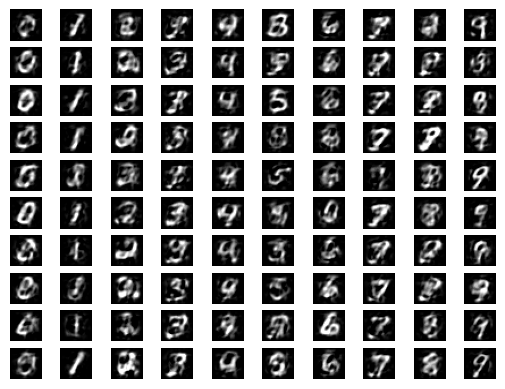

In [46]:
model = crbm.load(f'{directory_path}/crbm_checkpoints/crbm_mnist_demo.pth')
one_hots = np.diag(np.ones(10))
fig, axes = plt.subplots(nrows=10, ncols=10)
images = []
for i in range(10):
    model.reset_seed(i)
    images.append(scaler.inverse_transform(
        model.reconstruct(v=np.zeros((10, 784)), c=one_hots, n_gibbs=10000, add_noise=False)
    ))
for j in range(len(images)):
    for k in range(10):
        image = np.clip(np.reshape(images[j][k], (28, 28)), 0, 255)
        axes[j][k].imshow(image, cmap='gray')
        axes[j][k].axis('off')
plt.axis('off')